In [1]:
import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
%cd '/content/gdrive/MyDrive/MLAI/NeuralStyle/Transfer'

/content/gdrive/MyDrive/MLAI/NeuralStyle/Transfer


In [5]:
import numpy as np
from keras.utils import get_file
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [44]:
base_image_path = get_file(fname = "mar.jpg", origin = 'http://nationofdragons.com/fldr/mar6.jpg')
#style_image_path = get_file(fname = "skyscraper.jpg", origin = 'http://nationofdragons.com/fldr/Starry_Night.jpg')
#style_image_path = get_file(fname = "skyscrapr.jpg", origin = 'https://americanindian.si.edu/sites/1/files/images/exhibitions/Dick-West-Spatial-Whorl-426.jpg')
#style_image_path = get_file(fname = "skyscrap.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/ib8d40ed65f35ce8b/version/1500388745/unmissable-paintings-in-europe-die-ideale-by-piet-mondrian.jpg')
#style_image_path = get_file(fname = "skyscra.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/iea0f9dc06abd4d9d/version/1500388125/unmissable-paintings-in-europe-la-nascita-di-venere-by-boticelli.jpg')
#style_image_path = get_file(fname = "skyscr.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/ie8120f8044f1cb95/version/1500387747/unmissable-paintings-in-europe-guernica-picasso.jpg')
#style_image_path = get_file(fname = "skysc.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/i31f41beba573734f/version/1500387364/unmissable-paintings-in-europe-the-scream-by-edvard-munch.jpg')
#style_image_path = get_file(fname = "skys.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/iae084f1a97e677ba/version/1500387708/unmissable-paintings-in-europe-las-meninas-velazquez.jpg')
style_image_path = get_file(fname = "sky.jpg", origin = 'https://image.jimcdn.com/app/cms/image/transf/none/path/sa6549607c78f5c11/image/ibce5d035f24dbcbb/version/1500387888/unmissable-paintings-in-europe-bal-du-moulin-de-la-galette-by-auguste-renoire.jpg')


196608/190569 [==============================] - 0s 0us/step


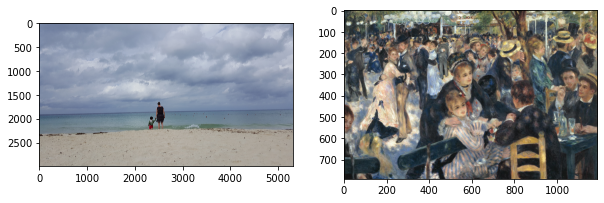

In [45]:
# read the image file in a numpy array
a = plt.imread(base_image_path)
b = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(10,10))
axarr[0].imshow(a)
axarr[1].imshow(b)
plt.show()

In [8]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [9]:
def style_cost(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [10]:
def content_cost(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [11]:
from tensorflow.keras.applications import vgg19
from keras.utils import plot_model

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [12]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [13]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combinar todas las imágenes en un mismo tensor.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Obtener los valores en todas las capas para las tres imágenes
    features = feature_extractor(input_tensor)

    #3. Inicializar el coste
    loss = tf.zeros(shape=())

    # 4. Extraer las capas de contenido + coste de contenido
    layer_features = features[content_layer]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * content_cost(
        base_image_features, combination_features
    )
    # 5. Extraer las capas de estilo + coste de estilo
    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_cost(style_reference_features, combination_features)
        loss += (style_weight / len(style_layers)) * sl

    return loss

In [14]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [15]:
import keras
from tensorflow.keras.applications import vgg19
import numpy as np

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [16]:
def deprocess_image(x):

    # Convertimos el tensor en Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [17]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save model and image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

In [1]:
from keras.optimizers import SGD

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = SGD( keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=150.0, decay_steps=150, decay_rate=0.90 ))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads( combination_image, base_image, style_reference_image )
    optimizer.apply_gradients([(grads, combination_image)])
    print("Iteration %d: loss=%.2f" % (i, loss))
    if i % 100 == 0:        
        result_saver(i)

NameError: ignored